In [1]:
import pandas as pd
from dask import dataframe as dk
import numpy as np
#!pip install pandas --upgrade
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest':  bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv', dtype=data_types)

In [2]:
poverty = pd.read_csv('poverty.csv')
poverty = poverty.drop('COMMUNITY AREA NAME', 1)
poverty.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [3]:
#  Remove unwanted columns from the data
# Add 'Date' back in when RJ fixes the datetime converter
useful_columns = ['IUCR', 'Location Description', 'Arrest', 'Domestic', 'Community Area', 'Year']
data_full = df[useful_columns]

In [4]:
# Merge with the poverty dataframe
data_full = data.rename(columns={'Community Area': 'Community Area Number'})
data_full = dk.merge(data_full, poverty, how='right', on='Community Area Number')

In [5]:
# Also resample to a smaller size for now
num_records = 100000
data = data_full.sample(num_records, replace=True)
data = data.dropna()
data.tail()

,IUCR,Location Description,Arrest,Domestic,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
99994,0320,STREET,True,False,9.0,2004,1.1,3.3,6.5,7.4,35.3,40959,8.0
99995,0430,PARKING LOT/GARAGE(NON.RESID.),False,False,9.0,2010,1.1,3.3,6.5,7.4,35.3,40959,8.0
99996,0840,COMMERCIAL / BUSINESS OFFICE,False,False,9.0,2011,1.1,3.3,6.5,7.4,35.3,40959,8.0
99997,2826,POOL ROOM,False,True,9.0,2011,1.1,3.3,6.5,7.4,35.3,40959,8.0
99998,0890,RESIDENTIAL YARD (FRONT/BACK),False,False,9.0,2011,1.1,3.3,6.5,7.4,35.3,40959,8.0


In [6]:
size = 2000000
d_subset = data
dummy_vars = ['Year', 'IUCR', 'Location Description', 'Community Area Number']
#dummy_vars = ['Year']
# Takes about 2 minutes to run on all records, takes much less time to run on subset of 1 or 2 million
data = pd.get_dummies(d_subset, columns=dummy_vars, drop_first=True, sparse=True)

In [8]:
from sklearn.cross_validation import train_test_split

dep_var = ['Arrest']
indep_var = data.columns.values
indep_var = [x for x in indep_var if x not in dep_var]
X = data[indep_var]
y = data[dep_var]
# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
from sklearn import linear_model
lasso_alphas = [0.00001, 0.0001, 0.001, 0.01, 0.02]
clf = linear_model.LassoCV(n_alphas=len(lasso_alphas), alphas=lasso_alphas, n_jobs = -1)
clf.fit(X_train, y_train)

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.02], copy_X=True, cv=None,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=5, n_jobs=-1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [19]:
from sklearn import metrics
# Print the r^2 value for the lasso function
print clf.score(X_test, y_test)

0.544759975495


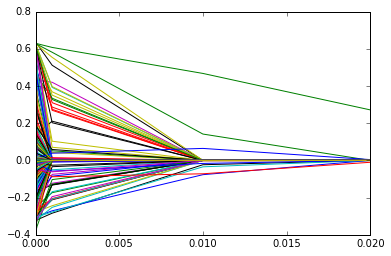

In [14]:
%matplotlib inline
from sklearn import linear_model
lasso_coeff = {}
for alpha in lasso_alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_coeff[alpha] = lasso.coef_
lpd = pd.DataFrame.from_dict(lasso_coeff, orient='index', )
lpd.columns = data.columns[1:]
lpd=lpd.sort_index()
lpd.plot(legend=False)